In [1]:
library(tidyverse)
library(ggplot2) # Plotting
library(mice) # Predictive Data Imputation for missing age values
library(randomForest) # For random forest model
library(dplyr)
library(MASS) # For stepAIC
library(faraway) # vif() <- variance inflation factors
library(mgcv) # GAMs
library(e1071) # Naive Bayes and Support Vector Machine Models
library(caret) # K-Nearest Neighbor
library(nnet)
library (ROCR) # For Precision, Recall, F1 and plots for model evaluation

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'mice'

The following object is masked from 'package:tidyr':

    complete

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select


Attaching package: 'faraway'

The following object is masked from 'package:mice':

    mammalsleep

Loading required package: nlme

Attaching package: 'nlme'

The following object is

In [2]:
train = set.seed(99)
train = read.csv("train.csv", stringsAsFactors = F)
test = read.csv("test.csv", stringsAsFactors = F)
testSurvived = read.csv("gender_submission.csv", stringsAsFactors = F)

test$Survived = testSurvived$Survived

full = bind_rows(train, test)
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


# Feature Engineering

Extract the title from the name of the passenger.

In [3]:
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)

table(full$Sex, full$Title)

        
         Capt Col Don Dona  Dr Jonkheer Lady Major Master Miss Mlle Mme  Mr Mrs
  female    0   0   0    1   1        0    1     0      0  260    2   1   0 197
  male      1   4   1    0   7        1    0     2     61    0    0   0 757   0
        
          Ms Rev Sir the Countess
  female   2   0   0            1
  male     0   8   1            0

In [4]:
rare_titles = c("Dona", "Lady", "the Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer")

# Rename some of the overlapping titles
full$Title[full$Title == "Ms"] <- "Miss"
full$Title[full$Title == "Mlle"] <- "Miss"
full$Title[full$Title == "Mme"] <- "Mrs"
full$Title[full$Title %in% rare_titles] <- "Rare_Title"

table(full$Sex, full$Title)

        
         Master Miss  Mr Mrs Rare_Title
  female      0  264   0 198          4
  male       61    0 757   0         25

Also want to grab the surnames

In [5]:
full$Surname = sapply(full$Name, function(x) strsplit(x, split = '[,.]')[[1]][1])
                      
nlevels(factor(full$Surname))

[1] 875

Now lets look at family size

In [6]:
# Create a variable for the total number of people in each family
full$Fsize = full$SibSp + full$Parch + 1

# Create a variable for all family info
full$Family = paste(full$Surname, full$Fsize, sep="_")

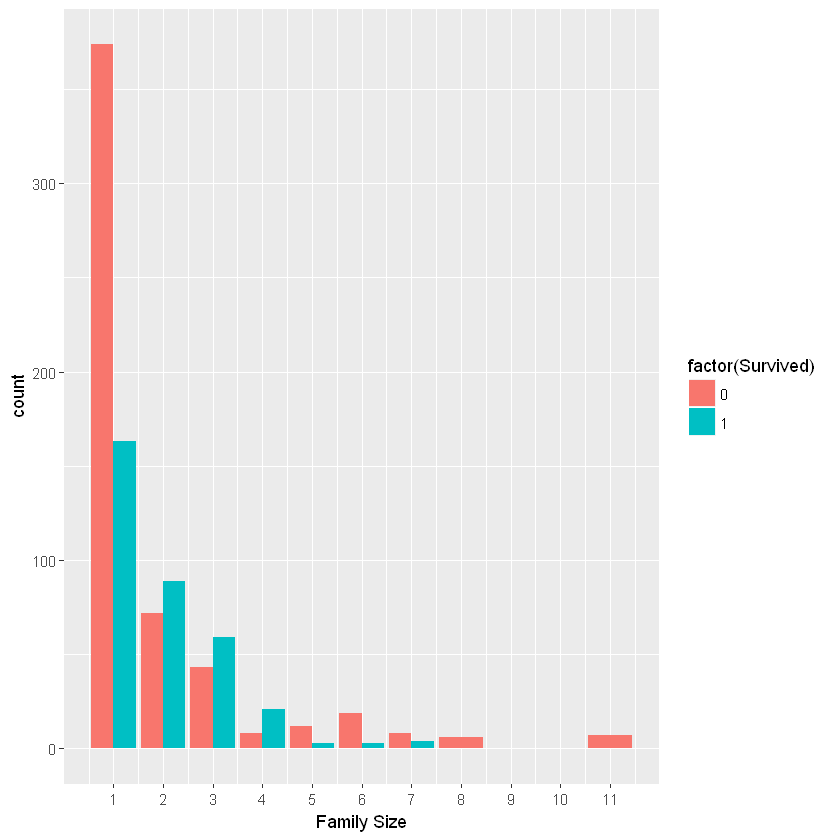

In [7]:
ggplot(full[1:891, ], aes(x = Fsize, fill = factor(Survived))) + 
    geom_bar(stat="count", position = "dodge") + 
    scale_x_continuous(breaks=c(1:11)) +
    labs(x = "Family Size")

Notice that there appears to be a penalty to survival for singletons and people with family sizes of 5 or greater.

In [8]:
# ggplot(full[1:891, ], aes(x = Pclass, fill = factor(Survived))) + 
#     geom_bar(stat = "count", position = "dodge") +
#     facet_grid(.~Sex) +
#     labs(fill = "Survived", x = "Class", y = "Count", title = "Number Survived per Class") +
#     scale_fill_manual(values = c("turquoise3", "darkorchid3"), labels = c("Died", "Survived"))

In [9]:
# ggplot(full[1:891, ], aes(x = Age, fill = factor(Survived))) + 
#     geom_histogram() +
#     facet_grid(.~Sex) +
#     labs(fill = "Survived", x = "Age", y = "Count", title = "Number Survived Per Age") +
#     scale_fill_manual(values = c("turquoise3", "darkorchid3"), labels = c("Died", "Survived"))

In [10]:
# ggplot(full[1:891, ], aes(x = Sex, fill = factor(Survived))) + 
#     geom_bar(stat = "count", position = "dodge")

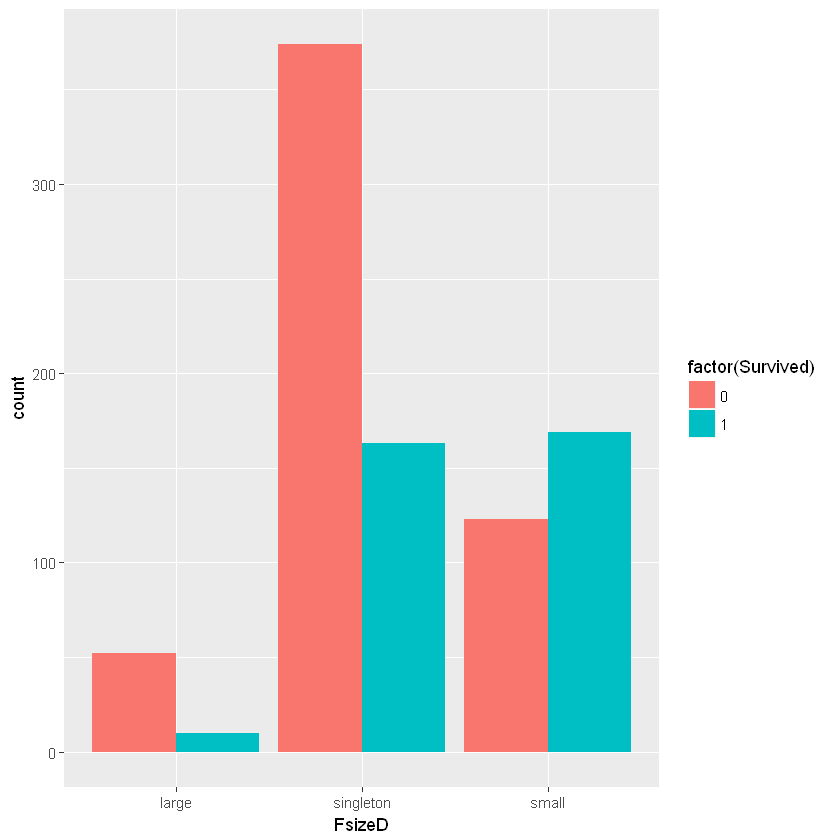

In [11]:
# Lets make a discrete family size varaible
full$FsizeD[full$Fsize == 1] = "singleton"
full$FsizeD[full$Fsize <= 4 & full$Fsize > 1] = "small"
full$FsizeD[full$Fsize >= 5] = "large"

ggplot(full[1:891, ], aes(x = FsizeD, fill = factor(Survived))) + 
    geom_bar(stat="count", position = "dodge")

In [12]:
# Create a deck varaible
full$Deck = factor(sapply(full$Cabin, function(x) strsplit(x, NULL)[[1]][1]))

# Data Cleaning

In [13]:
# Start with embarked data. Rows missing data are 62 and 830
# get rid of our missing passenger IDs
# Because their fare price is most similar to first class, and most first class departed from 'C', we will assign that.
full$Embarked[c(62, 830)] = 'S'

In [14]:
# The passenger on row 1044 has an NA fare value
full[1044, ]
# Notice that their Pclass is 3 and their embarked is 'S'. So can assign the median fare of those groups.
full$Fare[1044] = median(full[full$Pclass == 3 & full$Embarked == 'S', ]$Fare, na.rm = TRUE)
# Median fare was 8.05
full[1044, ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1044,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NA,,S,Mr,Storey,1,Storey_1,singleton,NA


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Surname,Fsize,Family,FsizeD,Deck
1044,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,,S,Mr,Storey,1,Storey_1,singleton,NA


In [15]:
# There are a few missing age values in the data
sum(is.na(full$Age))
# Will use predictive imputation to fill those.
# Start by factorizing the factor variables
factor_vars = c("PassengerId", "Pclass", "Sex", "Embarked", "Title", "Surname", "Family", "FsizeD")

full[factor_vars] = lapply(full[factor_vars], function(x) as.factor(x))
            
set.seed(129)
                           
# Use mice package to perform imputation, excluding certain variables that aren't useful
mice_mod = mice(full[, !names(full) %in% c("PassengerId", 'Name', 'Ticket', 'Cabin', 'Family', 'Surname', 'Survived')], method = 'rf')
                           

[1] 263


 iter imp variable
  1   1  Age  Deck
  1   2  Age  Deck
  1   3  Age  Deck
  1   4  Age  Deck
  1   5  Age  Deck
  2   1  Age  Deck
  2   2  Age  Deck
  2   3  Age  Deck
  2   4  Age  Deck
  2   5  Age  Deck
  3   1  Age  Deck
  3   2  Age  Deck
  3   3  Age  Deck
  3   4  Age  Deck
  3   5  Age  Deck
  4   1  Age  Deck
  4   2  Age  Deck
  4   3  Age  Deck
  4   4  Age  Deck
  4   5  Age  Deck
  5   1  Age  Deck
  5   2  Age  Deck
  5   3  Age  Deck
  5   4  Age  Deck
  5   5  Age  Deck


In [16]:
mice_output = complete(mice_mod)

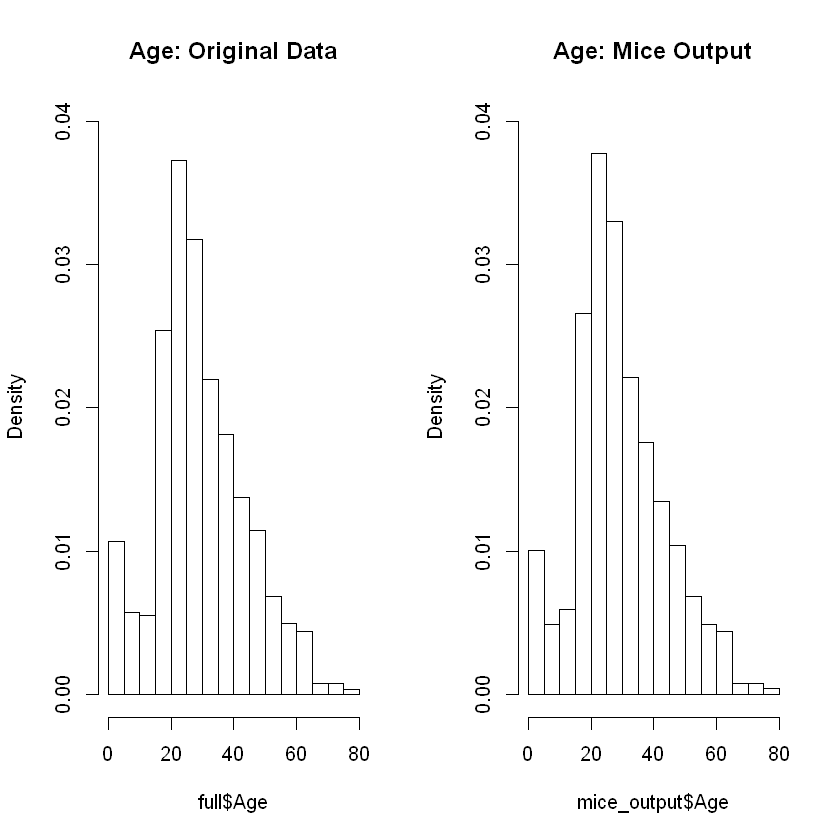

In [17]:
par(mfrow = c(1,2))
hist(full$Age, freq = F, main = "Age: Original Data", ylim = c(0, 0.04))
hist(mice_output$Age, freq = F, main = "Age: Mice Output", ylim = c(0, 0.04))

In [18]:
# hist(full$Age, freq = F, main = "Age: Original Data", xlab = "Age", ylim = c(0, 0.04), col = "mediumorchid3")

In [19]:
# hist(mice_output$Age, freq = F, main = "Age: Predicted Output", xlab = "Age", ylim = c(0, 0.04), col = "mediumorchid3")

In [20]:
# Things look about equal in the above plots. Replace the age column in the full model with the one in the mice model
full$Age = mice_output$Age
sum(is.na(full$Age))

[1] 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


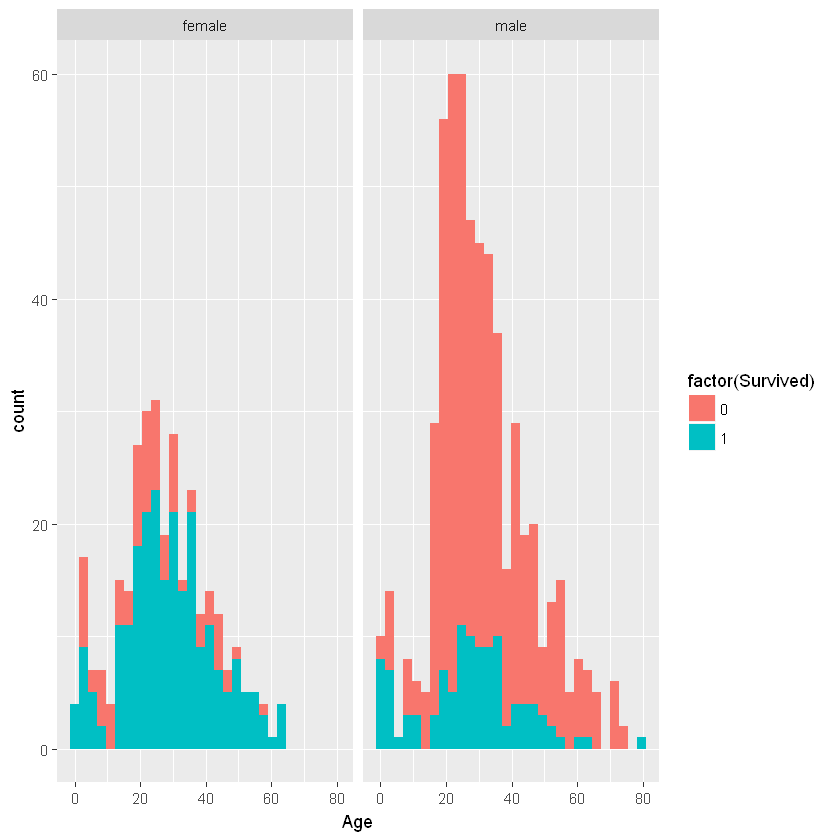

In [21]:
# Lets take a look at the relationship between age and survival
ggplot(full[1:891, ], aes(x = Age, fill = factor(Survived))) + 
    geom_histogram() +
    facet_grid(.~Sex)

In [22]:
# Lets do some more feature engineering with the full age varaibles
# Determine if people are children or mothers
# children are anyone under the age of 18
full$Child[full$Age < 18] = 'Child'
full$Child[full$Age >= 18] = 'Adult'
full$Child = factor(full$Child)
table(full$Child, full$Survived)

       
          0   1
  Adult 711 405
  Child 104  89

In [23]:
# A mother is someone who is female, over 18, has at least 1 child, and does not have the title "Miss"
full$Mother = "Not_Mother"
full$Mother[full$Sex == "female" & full$Age > 18 & full$Title != "Miss" & full$Parch > 0] = "Mother"
full$Mother = full$Mother
table(full$Mother, full$Survived)

            
               0   1
  Mother      16  68
  Not_Mother 799 426

In [24]:
md.pattern(full)

Warning message in data.matrix(x):
"NAs introduced by coercion"Warning message in data.matrix(x):
"NAs introduced by coercion"Warning message in data.matrix(x):
"NAs introduced by coercion"Warning message in data.matrix(x):
"NAs introduced by coercion"

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,...,Fsize,Family,FsizeD,Child,Ticket,Deck,Name,Cabin,Mother,
211,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,3
84,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,1,0,0,0,4
746,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,4
268,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,5
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,352,1014,1309,1309,1309,5293


In [25]:
# Now we start predicting the results. Return the data to the training and test sets
full = full %>% mutate_if(is.character, as.factor)
train = full[1:891, ]
test = full[892: 1309, ]

# Random Forest Model

In [26]:
# Build a model. This will be a random forest
set.seed(754)

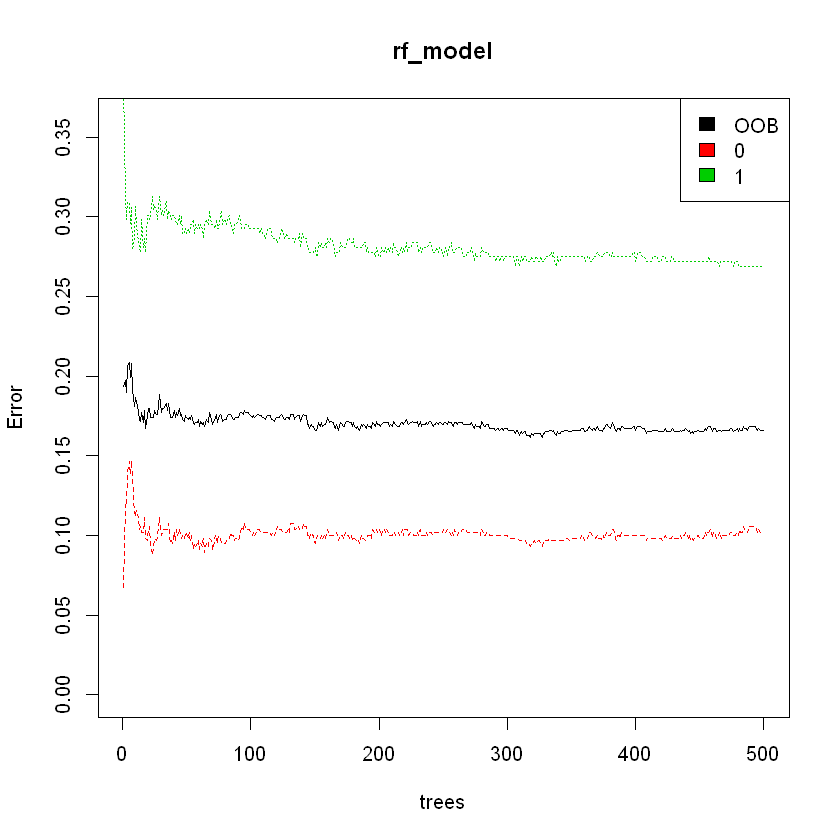

In [27]:
rf_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + SibSp + Parch + 
                                            Fare + Embarked + Title + 
                                            FsizeD + Child + Mother,
                                            data = train)

# Show model error
plot(rf_model, ylim=c(0,0.36))
legend('topright', colnames(rf_model$err.rate), col=1:3, fill=1:3)

The black line shows the overall error rate, which falls below 20%. The red and green lines show the error rate for the 'died' and 'survived' respectively. Right now, we predict deaths much better than we're predicting survival.

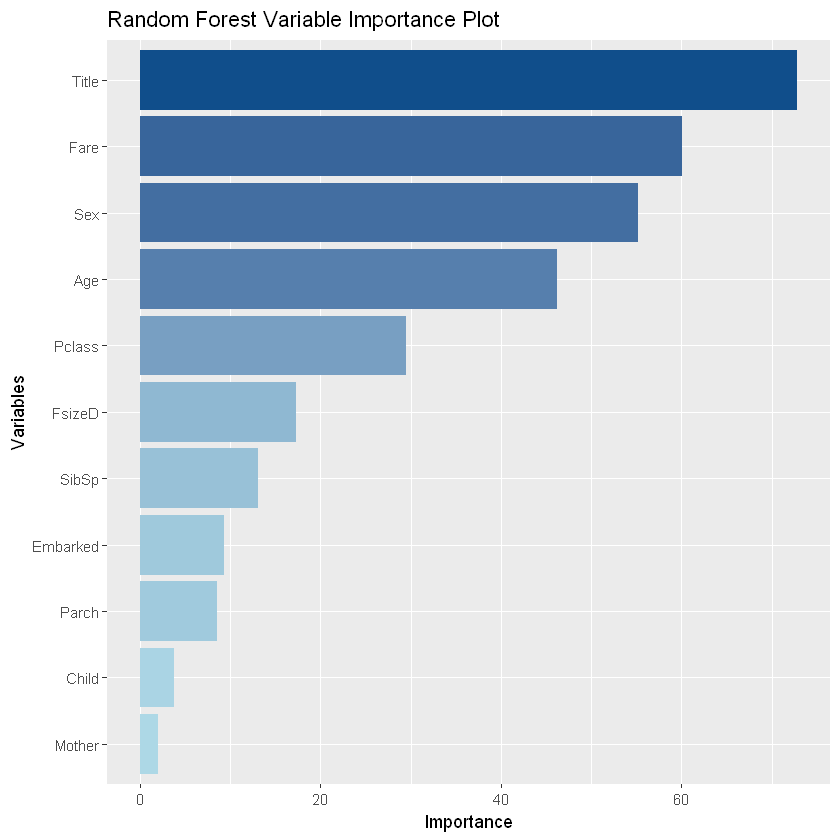

In [28]:
# Lets find the importance of each variable
importance = importance(rf_model)
varImportance = data.frame(Variables = row.names(importance), Importance = round(importance[ , 'MeanDecreaseGini'], 2))
# Order the variables based on importance
rankImportance = varImportance %>% mutate(Rank = paste0('#', dense_rank(desc(Importance))))
# Visualize the relative importance of each variable
ggplot(rankImportance, aes(x = reorder(Variables, Importance), y = Importance, fill = Importance)) +
    geom_bar(stat = "identity") + 
#     geom_text(aes(x = Variables, y = 0.5, label = Rank),
#         hjust = 0, vjust = 0.55, size = 4, colour = 'orange') + 
    scale_fill_gradient(low = "lightblue", high = "dodgerblue4") + 
    labs(x = 'Variables', title = "Random Forest Variable Importance Plot") + 
    coord_flip() + 
    theme(legend.position = "none")

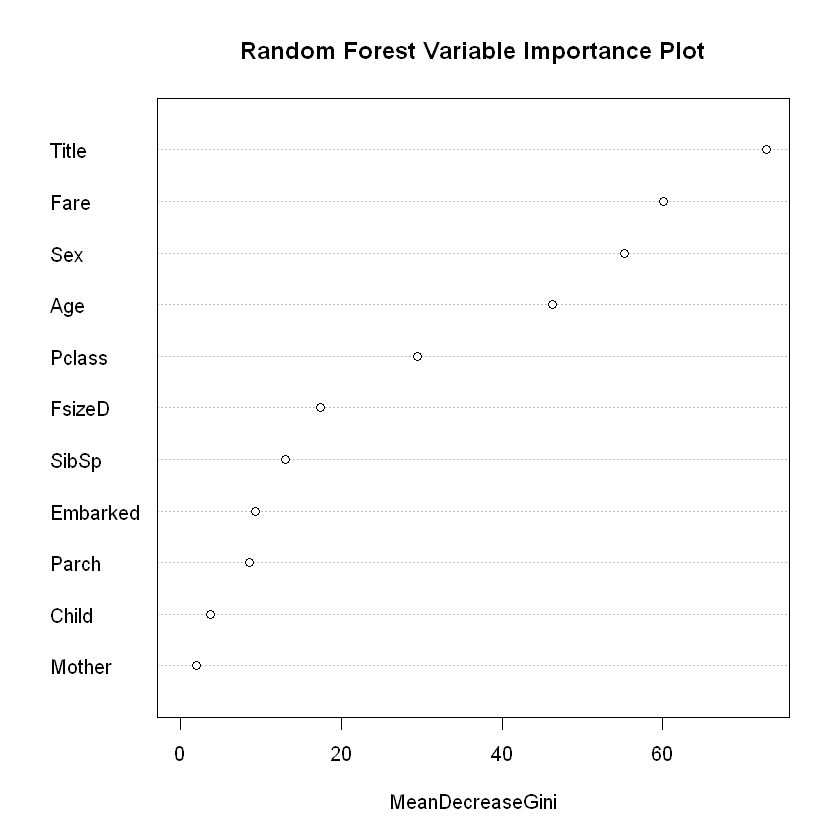

In [29]:
# Same plot, different look
varImpPlot(rf_model, main = "Random Forest Variable Importance Plot")

In [30]:
rf_predict = predict(rf_model, test)

rf_accuracy = mean(rf_predict == test$Survived)
rf_accuracy

[1] 0.8875598

In [31]:
rf_prop_survived = sum(as.integer(rf_predict) - 1) / length(test$Survived)

predictions = as.factor(rf_predict)
y = as.factor(test$Survived)

rf_precision <- posPredValue(predictions, y, positive="1")
rf_recall <- sensitivity(predictions, y, positive="1")

rf_F1 <- (2 * rf_precision * rf_recall) / (rf_precision + rf_recall)

rf_precision
rf_recall
rf_F1

rf_results = c("Random Forest", rf_accuracy, rf_precision, rf_recall, rf_F1, rf_prop_survived, 1 - rf_prop_survived)

[1] 0.8431373

[1] 0.8486842

[1] 0.8459016

In [32]:
rf_red_model <- randomForest(factor(Survived) ~ Pclass + Sex + Age + Fare + Title + FsizeD, data = train)

rf_red_predict = predict(rf_red_model, test)

rf_red_accuracy = mean(rf_red_predict == test$Survived)
rf_red_accuracy

[1] 0.9138756

In [33]:
rf_red_prop_survived = sum(as.integer(rf_red_predict) - 1) / length(test$Survived)

predictions = as.factor(rf_red_predict)
y = as.factor(test$Survived)

rf_red_precision <- posPredValue(predictions, y, positive="1")
rf_red_recall <- sensitivity(predictions, y, positive="1")

rf_red_F1 <- (2 * rf_red_precision * rf_red_recall) / (rf_red_precision + rf_red_recall)

rf_red_precision
rf_red_recall
rf_red_F1

rf_red_results = c("Reduced Random Forest", rf_red_accuracy, rf_red_precision, rf_red_recall, rf_red_F1, rf_red_prop_survived, 1 - rf_red_prop_survived)

[1] 0.8670886

[1] 0.9013158

[1] 0.883871

# Logistic Regression Model

In [34]:
# Fit a logistic regression model on all the same variables as the random forest model
glm_model = glm(Survived ~ Pclass + Sex + Age + SibSp + Parch + 
                        Fare + Embarked + Title + 
                        FsizeD + Child + Mother,
                        data = train, family = binomial)

glm_probs = glm_model %>% predict(test, type = "response")
glm_predict = ifelse(glm_probs > 0.5, 1, 0)
# test$glm_predict = glm_predict

glm_accuracy = mean(glm_predict == test$Survived)
glm_accuracy

[1] 0.930622

In [35]:
glm_prop_survived = sum(as.integer(glm_predict)) / length(test$Survived)

predictions = as.factor(glm_predict)
y = as.factor(test$Survived)

glm_precision <- posPredValue(predictions, y, positive="1")
glm_recall <- sensitivity(predictions, y, positive="1")

glm_F1 <- (2 * glm_precision * glm_recall) / (glm_precision + glm_recall)

glm_prop_survived
glm_precision
glm_recall
glm_F1

glm_results = c("GLM", glm_accuracy, glm_precision, glm_recall, glm_F1, glm_prop_survived, 1 - glm_prop_survived)

[1] 0.4090909

[1] 0.8596491

[1] 0.9671053

[1] 0.9102167

In [36]:
# Repeat prediction with simplified model
# Use AIC to reduce model to simplist state
modAIC = stepAIC(glm_model)

AIC_probs = modAIC %>% predict(test, type = "response")
AIC_predict = ifelse(AIC_probs > 0.5, 1, 0)

AIC_accuracy = mean(AIC_predict == test$Survived)
AIC_accuracy

Start:  AIC=747.6
Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + 
    Title + FsizeD + Child + Mother

           Df Deviance    AIC
- SibSp     1   711.68 745.68
- Mother    1   711.92 745.92
- Parch     1   712.07 746.07
- Embarked  2   714.12 746.12
- Child     1   712.16 746.16
- Fare      1   713.54 747.54
<none>          711.60 747.60
- Sex       1   717.20 751.20
- Age       1   718.19 752.19
- FsizeD    2   725.11 757.11
- Pclass    2   753.90 785.90
- Title     4   762.21 790.21

Step:  AIC=745.68
Survived ~ Pclass + Sex + Age + Parch + Fare + Embarked + Title + 
    FsizeD + Child + Mother

           Df Deviance    AIC
- Mother    1   711.99 743.99
- Embarked  2   714.27 744.27
- Child     1   712.28 744.28
- Parch     1   712.52 744.52
- Fare      1   713.62 745.62
<none>          711.68 745.68
- Sex       1   717.31 749.31
- Age       1   718.28 750.28
- FsizeD    2   748.02 778.02
- Pclass    2   754.41 784.41
- Title     4   762.21 788.21

Step:  AIC=7

[1] 0.9425837

In [37]:
AIC_prop_survived = sum(as.integer(AIC_predict)) / length(test$Survived)

predictions = as.factor(AIC_predict)
y = as.factor(test$Survived)

AIC_precision <- posPredValue(predictions, y, positive="1")
AIC_recall <- sensitivity(predictions, y, positive="1")

AIC_F1 <- (2 * AIC_precision * AIC_recall) / (AIC_precision + AIC_recall)

AIC_prop_survived
AIC_precision
AIC_recall
AIC_F1

AIC_results = c("Reduced GLM", AIC_accuracy, AIC_precision, AIC_recall, AIC_F1, AIC_prop_survived, 1 - AIC_prop_survived)

[1] 0.3971292

[1] 0.8855422

[1] 0.9671053

[1] 0.9245283

# Generalize Additive Model

In [38]:
# With all predictors
GAM_model = gam(Survived ~ Pclass + Sex + s(Age) + SibSp + Parch + 
                s(Fare) + Embarked + Title + 
                FsizeD + Child + Mother, data = train)
summary(GAM_model)


Family: gaussian 
Link function: identity 

Formula:
Survived ~ Pclass + Sex + s(Age) + SibSp + Parch + s(Fare) + 
    Embarked + Title + FsizeD + Child + Mother

Parametric coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.932206   0.283949   3.283  0.00107 ** 
Pclass2          -0.137724   0.052899  -2.604  0.00938 ** 
Pclass3          -0.245491   0.058004  -4.232 2.56e-05 ***
Sexmale          -0.646715   0.222586  -2.905  0.00376 ** 
SibSp             0.003641   0.023233   0.157  0.87550    
Parch             0.044378   0.029095   1.525  0.12756    
EmbarkedQ         0.012609   0.053734   0.235  0.81453    
EmbarkedS        -0.040687   0.033588  -1.211  0.22609    
TitleMiss        -0.713977   0.234709  -3.042  0.00242 ** 
TitleMr          -0.613569   0.080831  -7.591 8.22e-14 ***
TitleMrs         -0.621166   0.240008  -2.588  0.00981 ** 
TitleRare_Title  -0.628412   0.114712  -5.478 5.63e-08 ***
FsizeDsingleton   0.643481   0.132141   4.87

In [39]:
GAM_probs = GAM_model %>% predict(test, type = "response")
GAM_predict = ifelse(GAM_probs > 0.5, 1, 0)
# test$glm_predict = glm_predict

GAM_accuracy = mean(GAM_predict == test$Survived)
GAM_accuracy

[1] 0.9521531

In [40]:
GAM_prop_survived = sum(as.integer(GAM_predict)) / length(test$Survived)

predictions = as.factor(GAM_predict)
y = as.factor(test$Survived)

GAM_precision <- posPredValue(predictions, y, positive="1")
GAM_recall <- sensitivity(predictions, y, positive="1")

GAM_F1 <- (2 * GAM_precision * GAM_recall) / (GAM_precision + GAM_recall)

GAM_prop_survived
GAM_precision
GAM_recall
GAM_F1

GAM_results = c("GAM", GAM_accuracy, GAM_precision, GAM_recall, GAM_F1, GAM_prop_survived, 1 - GAM_prop_survived)

[1] 0.3923445

[1] 0.902439

[1] 0.9736842

[1] 0.9367089

In [41]:
GAM_AIC_model = gam(Survived ~ Pclass + Sex + s(Age) + s(Fare) + Title + FsizeD, data = train)

GAM_AIC_probs = GAM_AIC_model %>% predict(test, type = "response")
GAM_AIC_predict = ifelse(GAM_AIC_probs > 0.5, 1, 0)
# test$glm_predict = glm_predict

GAM_AIC_accuracy = mean(GAM_AIC_predict == test$Survived)
GAM_AIC_accuracy

[1] 0.9497608

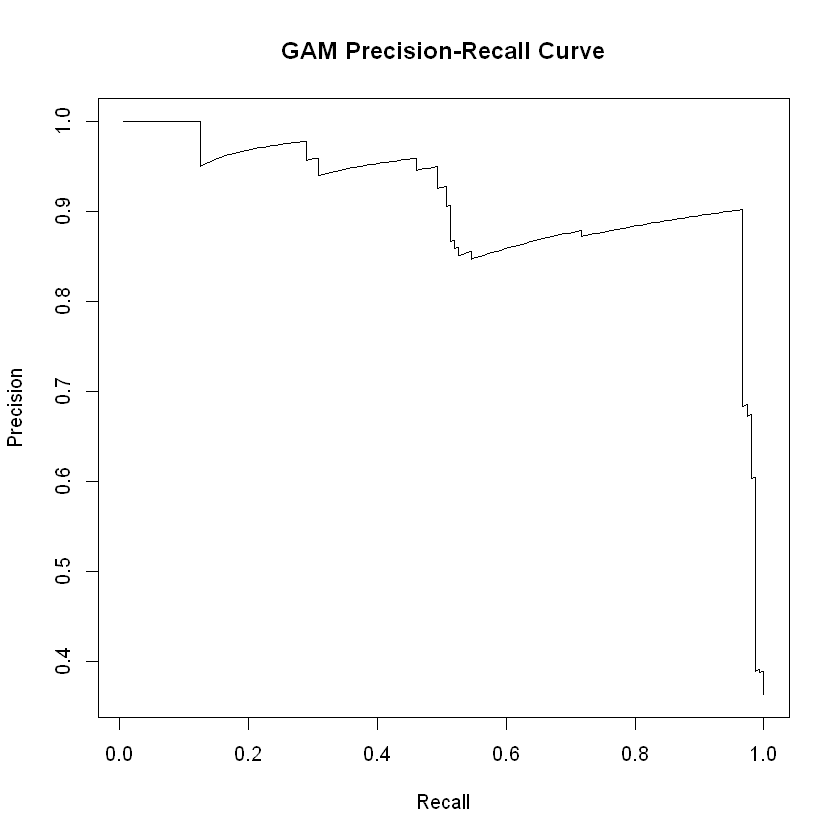

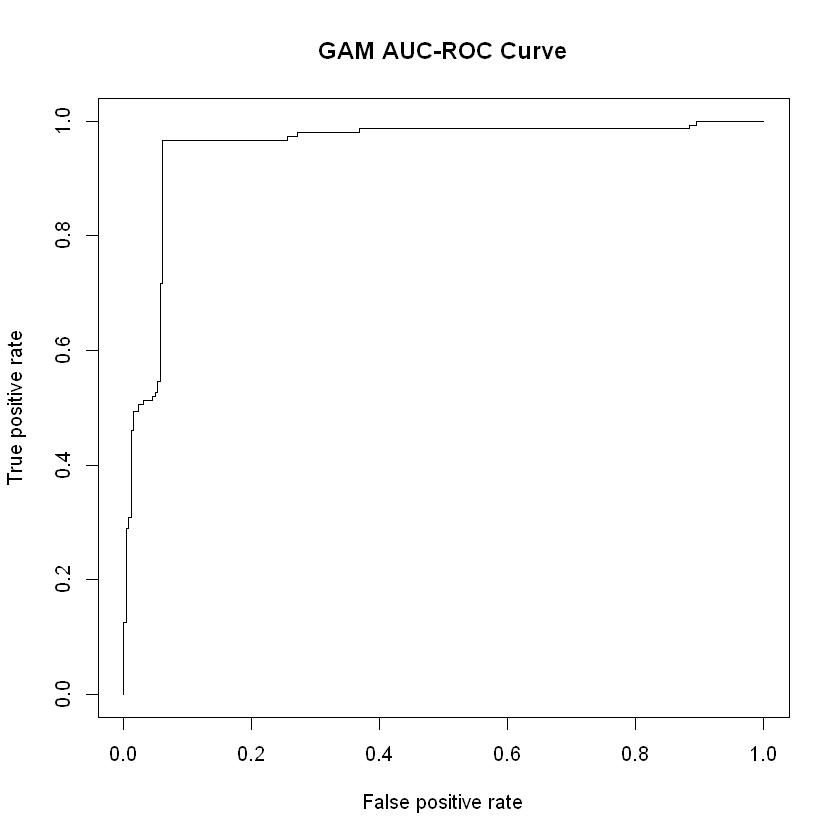

In [76]:
pred <- prediction(list(GAM_AIC_probs), test$Survived);

# Recall-Precision curve             
RP.perf <- performance(pred, "prec", "rec");
plot (RP.perf, main = "GAM Precision-Recall Curve");

# ROC curve
ROC.perf <- performance(pred, "tpr", "fpr");
plot (ROC.perf, main = "GAM AUC-ROC Curve");

# ROC area under the curve
auc.tmp <- performance(pred,"auc");
auc <- as.numeric(auc.tmp@y.values)

In [43]:
GAM_AIC_prop_survived = sum(as.integer(GAM_AIC_predict)) / length(test$Survived)

predictions = as.factor(GAM_AIC_predict)
y = as.factor(test$Survived)

GAM_AIC_precision <- posPredValue(predictions, y, positive="1")
GAM_AIC_recall <- sensitivity(predictions, y, positive="1")

GAM_AIC_F1 <- (2 * GAM_AIC_precision * GAM_AIC_recall) / (GAM_AIC_precision + GAM_AIC_recall)

GAM_AIC_prop_survived
GAM_AIC_precision
GAM_AIC_recall
GAM_AIC_F1

GAM_AIC_results = c("Reduced GAM", GAM_AIC_accuracy, GAM_AIC_precision, GAM_AIC_recall, GAM_AIC_F1, GAM_AIC_prop_survived, 1 - GAM_AIC_prop_survived)

[1] 0.3899522

[1] 0.9018405

[1] 0.9671053

[1] 0.9333333

GAM predicted that a passenger survived correctly 90% of the time (precision). Recall tells us that it predicted the survival of 97% of the people who actually surived.

# Naive Bayes

In [44]:
nb_model <- naiveBayes(Survived ~ Pclass + Sex + Age + 
                      SibSp + Parch + Fare + Embarked + 
                      Title + FsizeD + Child + Mother, data = train)
summary(nb_model)

nb_probs = predict(nb_model, test, type = "raw")
nb_predict = apply(nb_probs, 1, function(x) ifelse(x[1] > x[2], 0, 1))

nb_accuracy = mean(nb_predict == test$Survived)
nb_accuracy

        Length Class  Mode   
apriori  2     table  numeric
tables  11     -none- list   
levels   0     -none- NULL   
call     4     -none- call   

[1] 0.9354067

In [45]:
nb_prop_survived = sum(as.integer(nb_predict)) / length(test$Survived)

predictions = as.factor(nb_predict)
y = as.factor(test$Survived)

nb_precision <- posPredValue(predictions, y, positive="1")
nb_recall <- sensitivity(predictions, y, positive="1")

nb_F1 <- (2 * nb_precision * nb_recall) / (nb_precision + nb_recall)

nb_prop_survived
nb_precision
nb_recall
nb_F1

nb_results = c("Naive Bayes", nb_accuracy, nb_precision, nb_recall, nb_F1, nb_prop_survived, 1 - nb_prop_survived)

[1] 0.4090909

[1] 0.8654971

[1] 0.9736842

[1] 0.9164087

In [46]:
nb_red_model <- naiveBayes(Survived ~ Pclass + Sex + Age + Fare + Title + FsizeD, data = train)

summary(nb_red_model)

nb_red_probs = predict(nb_red_model, test, type = "raw")
nb_red_predict = apply(nb_red_probs, 1, function(x) ifelse(x[1] > x[2], 0, 1))

nb_red_accuracy = mean(nb_red_predict == test$Survived)
nb_red_accuracy

        Length Class  Mode   
apriori 2      table  numeric
tables  6      -none- list   
levels  0      -none- NULL   
call    4      -none- call   

[1] 0.9593301

In [47]:
nb_red_prop_survived = sum(as.integer(nb_red_predict)) / length(test$Survived)

predictions = as.factor(nb_red_predict)
y = as.factor(test$Survived)

nb_red_precision <- posPredValue(predictions, y, positive="1")
nb_red_recall <- sensitivity(predictions, y, positive="1")

nb_red_F1 <- (2 * nb_red_precision * nb_red_recall) / (nb_red_precision + nb_red_recall)

nb_red_prop_survived
nb_red_precision
nb_red_recall
nb_red_F1

nb_red_results = c("Reduced Naive Bayes", nb_red_accuracy, nb_red_precision, nb_red_recall, nb_red_F1, nb_red_prop_survived, 1 - nb_red_prop_survived)

[1] 0.3995215

[1] 0.9041916

[1] 0.9934211

[1] 0.9467085

# Linear Support Vector Machines

In [48]:
svm_model = svm(factor(Survived) ~ Pclass + Sex + Age + 
                      SibSp + Parch + Fare + Embarked + 
                      Title + FsizeD + Child + Mother, data = train[ ,-c(11, 18)], probability = TRUE)
# svm_model
# Had to remove the cabin and deck variables because it wasn't predicting the rows with the missing values
svm_predict = predict(svm_model, newdata = test[, -c(11, 18)], probability = TRUE)

svm_accuracy = mean(svm_predict == test$Survived)
svm_accuracy

[1] 0.9473684

In [49]:
svm_prop_survived = sum(as.integer(svm_predict) - 1) / length(test$Survived)

predictions = as.factor(svm_predict)
y = as.factor(test$Survived)

svm_precision <- posPredValue(predictions, y, positive="1")
svm_recall <- sensitivity(predictions, y, positive="1")

svm_F1 <- (2 * svm_precision * svm_recall) / (svm_precision + svm_recall)

svm_prop_survived
svm_precision
svm_recall
svm_F1

svm_results = c("Linear SVM", svm_accuracy, svm_precision, svm_recall, svm_F1, svm_prop_survived, 1 - svm_prop_survived)

[1] 0.3875598

[1] 0.9012346

[1] 0.9605263

[1] 0.9299363

In [50]:
# Reduced model based on AIC
svm_red_model = svm(factor(Survived) ~ Pclass + Sex + Age + Fare + Title + FsizeD, 
                        data = train[ ,-c(11, 18)], probability = TRUE)
# svm_model
# Had to remove the cabin and deck variables because it wasn't predicting the rows with the missing values
svm_red_predict = predict(svm_red_model, newdata = test[, -c(11, 18)], probability = TRUE)

svm_red_accuracy = mean(svm_red_predict == test$Survived)
svm_red_accuracy

[1] 0.9497608

In [51]:
svm_red_prop_survived = sum(as.integer(svm_red_predict) - 1) / length(test$Survived)

predictions = as.factor(svm_red_predict)
y = as.factor(test$Survived)

svm_red_precision <- posPredValue(predictions, y, positive="1")
svm_red_recall <- sensitivity(predictions, y, positive="1")

svm_red_F1 <- (2 * svm_red_precision * svm_red_recall) / (svm_red_precision + svm_red_recall)

svm_red_prop_survived
svm_red_precision
svm_red_recall
svm_red_F1

svm_red_results = c("Reduced Linear SVM", svm_red_accuracy, svm_red_precision, svm_red_recall, svm_red_F1, svm_red_prop_survived, 1 - svm_red_prop_survived)

[1] 0.3899522

[1] 0.9018405

[1] 0.9671053

[1] 0.9333333

# K-Nearest Neighbor

In [52]:
# set 5 rounds of cross validation
trControl = trainControl(method = "repeatedcv", repeats = 3)

knn_model = train(factor(Survived) ~ Pclass + Sex + Age + 
                     SibSp + Parch + Fare + Embarked + 
                     Title + FsizeD + Child + Mother,
                     method = "knn",
                     data = train,
                     preProcess = c("center", "scale"),
                     metric = "Accuracy",
                     tuneLength = 10)

k-Nearest Neighbors 

891 samples
 11 predictor
  2 classes: '0', '1' 

Pre-processing: centered (17), scaled (17) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 891, 891, 891, 891, 891, 891, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.7953647  0.5666089
   7  0.8047691  0.5849498
   9  0.8072740  0.5897875
  11  0.8105537  0.5967616
  13  0.8108234  0.5970836
  15  0.8131179  0.6021646
  17  0.8116273  0.5989416
  19  0.8131380  0.6022988
  21  0.8140254  0.6030239
  23  0.8157869  0.6062677

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 23.

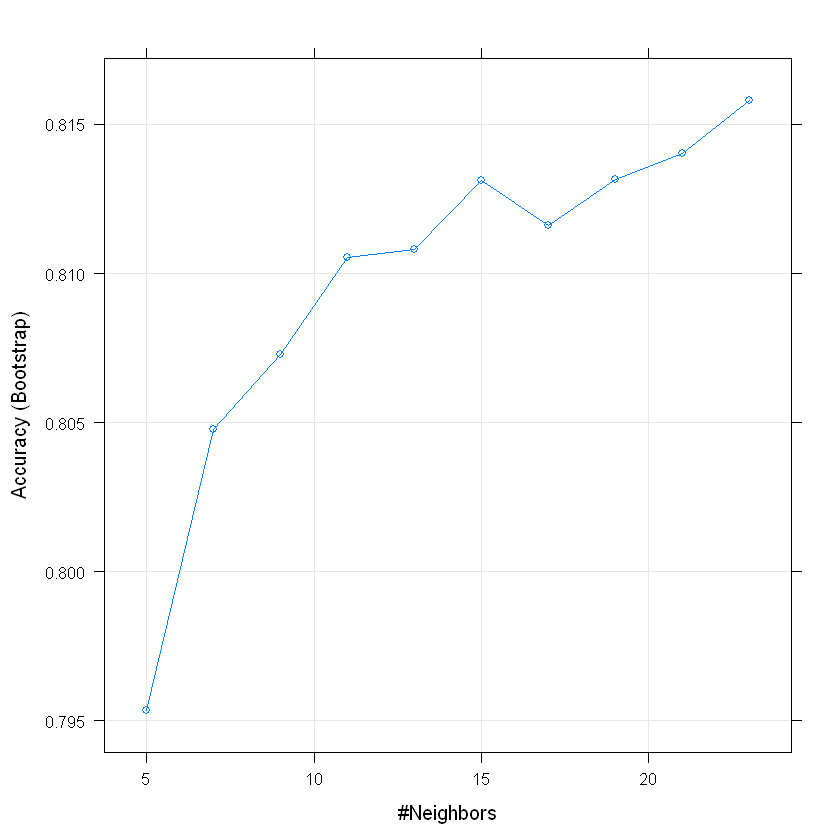

In [53]:
knn_model
plot(knn_model)

In [54]:
knn_predict = predict(knn_model, test)
# confusionMatrix(knn_predicts, test$Survived)
knn_accuracy = mean(knn_predict == test$Survived)
knn_accuracy

[1] 0.9090909

In [55]:
knn_prop_survived = sum(as.integer(knn_predict) - 1) / length(test$Survived)

predictions = as.factor(knn_predict)
y = as.factor(test$Survived)

knn_precision <- posPredValue(predictions, y, positive="1")
knn_recall <- sensitivity(predictions, y, positive="1")

knn_F1 <- (2 * knn_precision * knn_recall) / (knn_precision + knn_recall)

knn_prop_survived
knn_precision
knn_recall
knn_F1

knn_results = c("KNN", knn_accuracy, knn_precision, knn_recall, knn_F1, knn_prop_survived, 1 - knn_prop_survived)

[1] 0.3588517

[1] 0.88

[1] 0.8684211

[1] 0.8741722

k-Nearest Neighbors 

891 samples
  6 predictor
  2 classes: '0', '1' 

Pre-processing: centered (11), scaled (11) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 891, 891, 891, 891, 891, 891, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.8027184  0.5790163
   7  0.8106489  0.5923319
   9  0.8147932  0.6000310
  11  0.8172287  0.6037176
  13  0.8125190  0.5928456
  15  0.8053988  0.5762100
  17  0.8028183  0.5701848
  19  0.7996964  0.5637740
  21  0.8010044  0.5665344
  23  0.7979411  0.5579745

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 11.

[1] 0.8660287

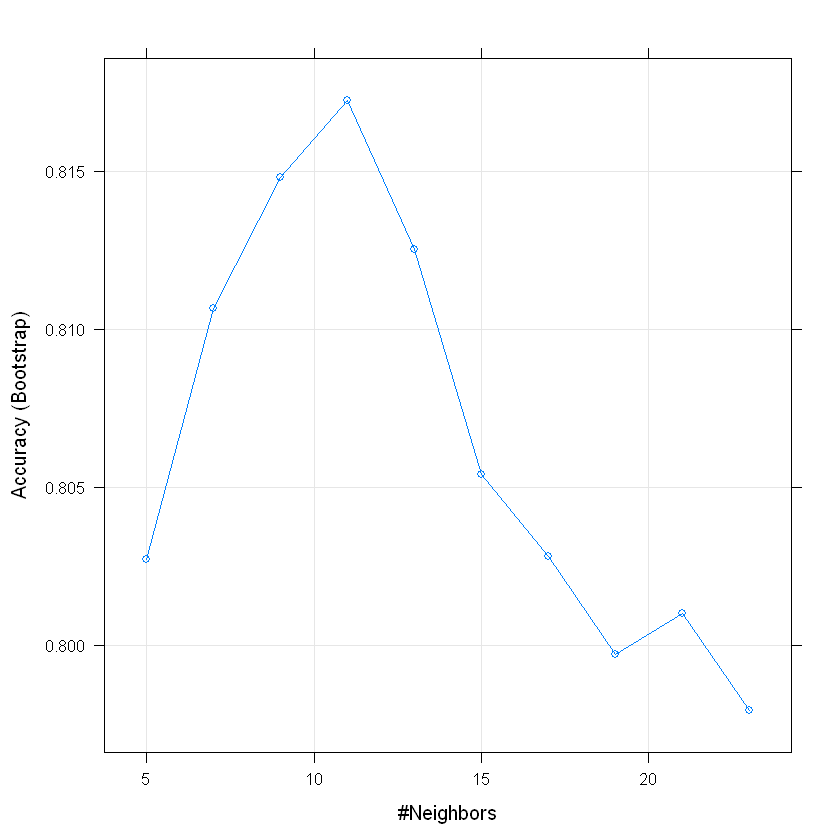

In [56]:
# Repeat with reduced model
# set 5 rounds of cross validation
trControl = trainControl(method = "repeatedcv", repeats = 3)

knn_red_model = train(factor(Survived) ~ Pclass + Sex + Age + Fare + Title + FsizeD,
                     method = "knn",
                     data = train,
                     preProcess = c("center", "scale"),
                     metric = "Accuracy",
                     tuneLength = 10)
knn_red_model
plot(knn_red_model)

knn_red_predict = predict(knn_red_model, test)
knn_red_accuracy = mean(knn_red_predict == test$Survived)
knn_red_accuracy

In [57]:
knn_red_prop_survived = sum(as.integer(knn_red_predict) - 1) / length(test$Survived)

predictions = as.factor(knn_red_predict)
y = as.factor(test$Survived)

knn_red_precision <- posPredValue(predictions, y, positive="1")
knn_red_recall <- sensitivity(predictions, y, positive="1")

knn_red_F1 <- (2 * knn_red_precision * knn_red_recall) / (knn_red_precision + knn_red_recall)

knn_red_prop_survived
knn_red_precision
knn_red_recall
knn_red_F1

knn_red_results = c("Reduced KNN", knn_red_accuracy, knn_red_precision, knn_red_recall, knn_red_F1, knn_red_prop_survived, 1 - knn_red_prop_survived)

[1] 0.3827751

[1] 0.8

[1] 0.8421053

[1] 0.8205128

# Neural Net

In [58]:
nn = nnet(Survived ~ Pclass + Sex + Age + SibSp + Parch + Fare + Embarked + Title + FsizeD + Child + Mother, 
          data = train, 
          size = 3)
nn

# weights:  58
initial  value 221.886169 
iter  10 value 155.112793
iter  20 value 117.459352
iter  30 value 110.444890
iter  40 value 108.559629
iter  50 value 108.044428
iter  60 value 107.855071
iter  70 value 103.218186
iter  80 value 102.832158
iter  90 value 102.767553
iter 100 value 102.754710
final  value 102.754710 
stopped after 100 iterations


a 17-3-1 network with 58 weights
inputs: Pclass2 Pclass3 Sexmale Age SibSp Parch Fare EmbarkedQ EmbarkedS TitleMiss TitleMr TitleMrs TitleRare_Title FsizeDsingleton FsizeDsmall ChildChild MotherNot_Mother 
output(s): Survived 
options were -

In [59]:
nn_probs = predict(nn, newdata = test, type = "raw")
nn_predict = ifelse(nn_probs > 0.5, 1, 0)

nn_accuracy = mean(nn_predict == test$Survived)
nn_accuracy

[1] 0.8875598

In [60]:
nn_prop_survived = sum(as.integer(nn_predict)) / length(test$Survived)

predictions = as.factor(nn_predict)
y = as.factor(test$Survived)

nn_precision <- posPredValue(predictions, y, positive="1")
nn_recall <- sensitivity(predictions, y, positive="1")

nn_F1 <- (2 * nn_precision * nn_recall) / (nn_precision + nn_recall)

nn_prop_survived
nn_precision
nn_recall
nn_F1

nn_results = c("Neural Net", nn_accuracy, nn_precision, nn_recall, nn_F1, nn_prop_survived, 1 - nn_prop_survived)

[1] 0.3564593

[1] 0.852349

[1] 0.8355263

[1] 0.8438538

In [61]:
# Reduced model
nn_red = nnet(Survived ~ Pclass + Sex + Age + Fare + Title + FsizeD, 
          data = train, 
          size = 3)
nn_red

nn_red_probs = predict(nn_red, newdata = test, type = "raw")
nn_red_predict = ifelse(nn_red_probs > 0.5, 1, 0)

nn_red_accuracy = mean(nn_red_predict == test$Survived)
nn_red_accuracy

# weights:  40
initial  value 224.871768 
iter  10 value 158.844068
iter  20 value 131.210619
iter  30 value 116.133578
iter  40 value 112.969894
iter  50 value 111.846118
iter  60 value 111.619177
iter  70 value 111.491310
iter  80 value 111.421229
iter  90 value 111.368063
iter 100 value 111.263512
final  value 111.263512 
stopped after 100 iterations


a 11-3-1 network with 40 weights
inputs: Pclass2 Pclass3 Sexmale Age Fare TitleMiss TitleMr TitleMrs TitleRare_Title FsizeDsingleton FsizeDsmall 
output(s): Survived 
options were -

[1] 0.923445

In [62]:
nn_red_prop_survived = sum(as.integer(nn_red_predict)) / length(test$Survived)

predictions = as.factor(nn_red_predict)
y = as.factor(test$Survived)

nn_red_precision <- posPredValue(predictions, y, positive="1")
nn_red_recall <- sensitivity(predictions, y, positive="1")

nn_red_F1 <- (2 * nn_red_precision * nn_red_recall) / (nn_red_precision + nn_red_recall)

nn_red_prop_survived
nn_red_precision
nn_red_recall
nn_red_F1

nn_red_results = c("Reduced Neural Net", nn_red_accuracy, nn_red_precision, nn_red_recall, nn_red_F1, nn_red_prop_survived, 1 - nn_red_prop_survived)

[1] 0.4162679

[1] 0.8448276

[1] 0.9671053

[1] 0.9018405

# Results

In [63]:
matrix(0, ncol = 3, nrow = 5)

0,0,0
0,0,0
0,0,0
0,0,0
0,0,0


In [64]:
results = data.frame(matrix(0, nrow = 14, ncol = 7))
results[1, ] = glm_results
results[2, ] = AIC_results
results[3, ] = GAM_results
results[4, ] = GAM_AIC_results
results[5, ] = nb_results
results[6, ] = nb_red_results
results[7, ] = knn_results
results[8, ] = knn_red_results
results[9, ] = rf_results
results[10, ] = rf_red_results
results[11, ] = svm_results
results[12, ] = svm_red_results
results[13, ] = nn_results
results[14, ] = nn_red_results

colnames(results) = c("Model", "% Accuracy", "Precision", "Recall", "F1", "% Survived", "% Died")

In [65]:
results

Model,% Accuracy,Precision,Recall,F1,% Survived,% Died
GLM,0.930622009569378,0.859649122807018,0.967105263157895,0.910216718266254,0.409090909090909,0.590909090909091
Reduced GLM,0.942583732057416,0.885542168674699,0.967105263157895,0.924528301886793,0.397129186602871,0.602870813397129
GAM,0.952153110047847,0.902439024390244,0.973684210526316,0.936708860759494,0.392344497607655,0.607655502392344
Reduced GAM,0.949760765550239,0.901840490797546,0.967105263157895,0.933333333333333,0.389952153110048,0.610047846889952
Naive Bayes,0.935406698564593,0.865497076023392,0.973684210526316,0.91640866873065,0.409090909090909,0.590909090909091
Reduced Naive Bayes,0.95933014354067,0.904191616766467,0.993421052631579,0.946708463949843,0.399521531100478,0.600478468899522
KNN,0.909090909090909,0.88,0.868421052631579,0.874172185430464,0.358851674641148,0.641148325358852
Reduced KNN,0.866028708133971,0.8,0.842105263157895,0.82051282051282,0.382775119617225,0.617224880382775
Random Forest,0.88755980861244,0.843137254901961,0.848684210526316,0.845901639344262,0.366028708133971,0.633971291866029
Reduced Random Forest,0.913875598086124,0.867088607594937,0.901315789473684,0.883870967741936,0.37799043062201,0.62200956937799


In [66]:
k = apply(results[ , -1], 2, function(x) as.double(x))
k = format(round(k, 4), nsmall = 4)

l = data.frame(k)
l$Model = results$Model
l = l[c(7, 1, 2, 3, 4, 5, 6)]
colnames(l) = c("Model", "% Accuracy", "Precision", "Recall", "F1", "% Survived", "% Died")
l

Model,% Accuracy,Precision,Recall,F1,% Survived,% Died
GLM,0.9306,0.8596,0.9671,0.9102,0.4091,0.5909
Reduced GLM,0.9426,0.8855,0.9671,0.9245,0.3971,0.6029
GAM,0.9522,0.9024,0.9737,0.9367,0.3923,0.6077
Reduced GAM,0.9498,0.9018,0.9671,0.9333,0.3900,0.6100
Naive Bayes,0.9354,0.8655,0.9737,0.9164,0.4091,0.5909
Reduced Naive Bayes,0.9593,0.9042,0.9934,0.9467,0.3995,0.6005
KNN,0.9091,0.8800,0.8684,0.8742,0.3589,0.6411
Reduced KNN,0.8660,0.8000,0.8421,0.8205,0.3828,0.6172
Random Forest,0.8876,0.8431,0.8487,0.8459,0.3660,0.6340
Reduced Random Forest,0.9139,0.8671,0.9013,0.8839,0.3780,0.6220


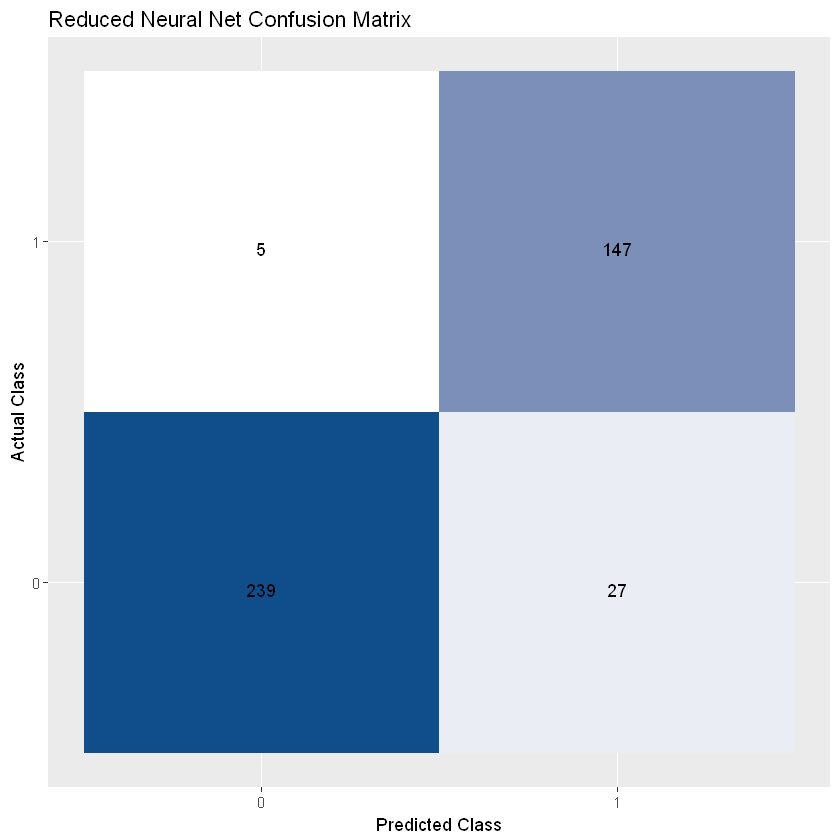

In [83]:
confusion_matrix <- as.data.frame(table(nn_red_predict, test$Survived))

ggplot(data = confusion_matrix,
       mapping = aes(x = nn_red_predict,
                     y = Var2)) +
  geom_tile(aes(fill = Freq)) +
  geom_text(aes(label = sprintf("%1.0f", Freq)), vjust = 1) +
  scale_fill_gradient(low = "white",
                      high = "dodgerblue4") + 
  theme(legend.position = "none") + 
  labs(x = "Predicted Class", y = "Actual Class", title = "Reduced Neural Net Confusion Matrix")

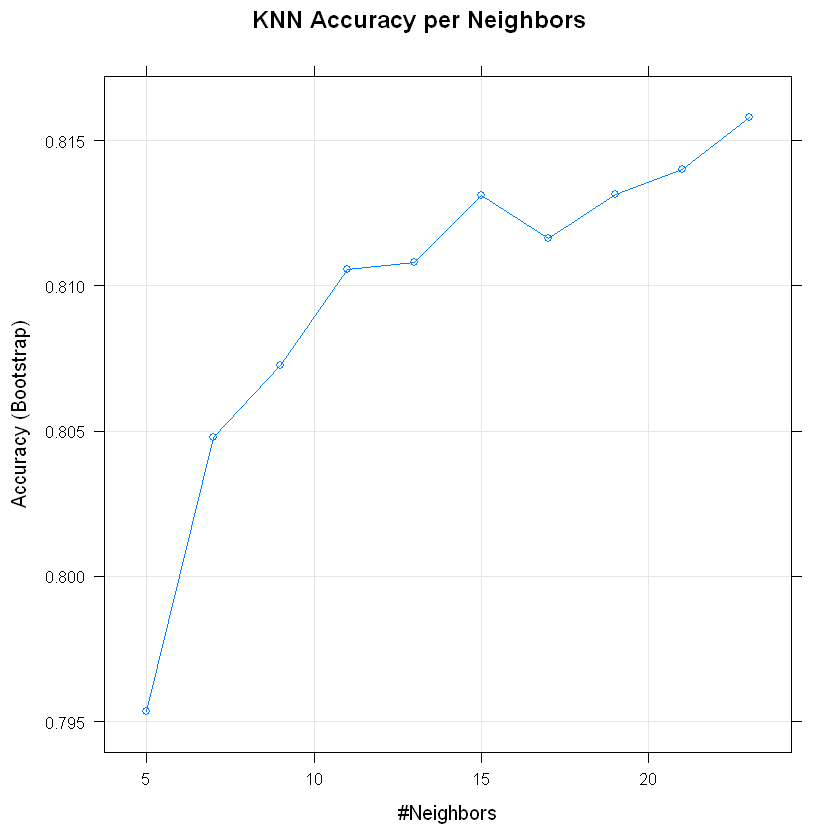

In [68]:
plot(knn_model, main = "KNN Accuracy per Neighbors")

In [85]:
sum(test$Survived == 1) / nrow(test)

[1] 0.3636364